# Clasificación de Reseñas de Películas
La premisa es que cada reseña de película puede ser positiva o negativa, con base en el contenido de la reseña.


In [ ]:
# Importamos los requerido
import string
from pathlib import Path
from typing import Dict, NamedTuple, List, Any

# from google.colab import drive
import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

tqdm.pandas()

# drive.mount('/content/drive')
# root = Path('/content/drive/Shareddrives/TC3002B/Reto')
root = Path.cwd()
print(f'{root=}')


class Dataset(NamedTuple):
    x_train: np.ndarray
    x_validate: np.ndarray
    x_test: np.ndarray
    y_train: np.ndarray
    y_validate: np.ndarray
    y_test: np.ndarray

    word_indices: Dict[str, int]


transformer = str.maketrans('', '', string.punctuation)


def normalize(text: str) -> str:
    return text.lower().replace("<br />", "").translate(transformer)


def word_index(text: str, indices: Dict[str, int]) -> List[int]:
    """Maps the text to a list word indices"""
    return [indices[word] for word in word_tokenize(text) if word in indices]


def load_data_stopwords(num_words: int,
                        seed: int = 123,
                        train_ratio: float = 0.5,
                        validate_ratio: float = 0.2,
                        shuffle: bool = True,
                        pad_maxlen: int = 100) -> Dataset:
    """"V1 of data loading. Manually remove English stopwords and create sequences"""
    from collections import Counter

    nltk.download('punkt')
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))
    stop_words.add('br')

    df = pd.read_csv(root / 'IMDB Dataset.csv',
                     dtype={'sentiment': 'category'})
    df['review'] = df['review'].progress_apply(normalize)

    all_reviews = ' '.join(tqdm(df['review'].values))
    counter = Counter(word for word in tqdm(word_tokenize(all_reviews))
                      if word not in stop_words)

    top_words = {
        word: idx
        for idx, (word, _) in enumerate(counter.most_common(num_words))
    }

    def transform(text):
        return word_index(text, top_words)

    x = df['review'].progress_apply(transform).values

    x = pad_sequences(x, maxlen=pad_maxlen)
    y = df['sentiment'].cat.codes.values

    x_train, x_test, y_train, y_test = train_test_split(x,
                                                        y,
                                                        test_size=train_ratio,
                                                        random_state=seed,
                                                        shuffle=shuffle)
    x_train, x_validate, y_train, y_validate = train_test_split(
        x_train,
        y_train,
        test_size=validate_ratio,
        random_state=seed,
        shuffle=shuffle)

    return Dataset(x_train, x_validate, x_test, y_train, y_validate, y_test,
                   top_words)


def load_data_default(num_words: int,
                      seed: int = 123,
                      train_ratio: Any = None,
                      validate_ratio: float = 0.2,
                      shuffle: bool = False,
                      pad_maxlen: int = 100) -> Dataset:
    """"V2 of data loading. Default Keras IMDB dataset without stopwords removal"""
    from keras.datasets import imdb

    (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words,
                                                          seed=seed)
    x_train = pad_sequences(x_train, maxlen=pad_maxlen)
    x_test = pad_sequences(x_test, maxlen=pad_maxlen)

    x_train, x_validate, y_train, y_validate = train_test_split(
        x_train,
        y_train,
        test_size=validate_ratio,
        random_state=seed,
        shuffle=shuffle)

    return Dataset(x_train, x_validate, x_test, y_train, y_validate, y_test,
                   imdb.get_word_index())


root=PosixPath('/content')


## Carga del Dataset y Prepación de los Datos


Tomamos las 20000 palabras más comunes y sus respectivos índices


In [ ]:
NUM_WORDS = 20000
# ds = load_data_stopwords(NUM_WORDS, train_ratio=0.5, validate_ratio=0.2, pad_maxlen=100)
ds = load_data_default(NUM_WORDS, train_ratio=0.5, validate_ratio=0.2, pad_maxlen=200)

1641221/1641221 [==============================] - 0s 0us/step


In [ ]:
ds.x_train.shape

(20000, 200)

## Construcción de la red


In [ ]:
# Configuración del Modelo
# Estos valores serán los que se pueden editar en el dashboard
vocab_size = 10000
embed_size = 32
epochs = 5
batch_size = 512
lstm_units = 128
# dropout_rate = 0.5


In [ ]:
# Crear Modelo LSTM
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Embedding
from tensorflow.keras.callbacks import EarlyStopping

# Definimos el modelo
model = Sequential()

model.add(Embedding(vocab_size, embed_size))

model.add(LSTM(lstm_units))

model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 lstm (LSTM)                 (None, 128)               82432     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 402,561
Trainable params: 402,561
Non-trainable params: 0
_________________________________________________________________


## Entrenamiento de la red
Entrenamos al modelo con la configuración definida anteriormente


In [ ]:
# Use early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(ds.x_train,
                    ds.y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(ds.x_validate, ds.y_validate),
                    callbacks=[early_stopping])


Epoch 1/5
40/40 [==============================] - 18s 232ms/step - loss: 0.6624 - accuracy: 0.5968 - val_loss: 0.6079 - val_accuracy: 0.6946
Epoch 2/5
40/40 [==============================] - 10s 241ms/step - loss: 0.6024 - accuracy: 0.7383 - val_loss: 0.4201 - val_accuracy: 0.8194
Epoch 3/5
40/40 [==============================] - 8s 208ms/step - loss: 0.3204 - accuracy: 0.8671 - val_loss: 0.3192 - val_accuracy: 0.8658
Epoch 4/5
40/40 [==============================] - 6s 155ms/step - loss: 0.2257 - accuracy: 0.9129 - val_loss: 0.3190 - val_accuracy: 0.8672
Epoch 5/5
40/40 [==============================] - 7s 187ms/step - loss: 0.1872 - accuracy: 0.9356 - val_loss: 0.3008 - val_accuracy: 0.8764


In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Ahora veamos cómo estuvo la función de pérdida durante el proceso de entrenamiento y validación

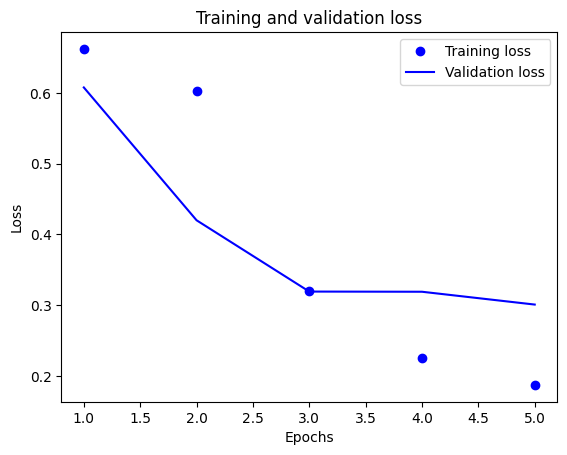

In [ ]:
import matplotlib.pyplot as plt


loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Seguidamente, hacemos lo mismo con el accuracy durante el proceso de entrenamiento y validación

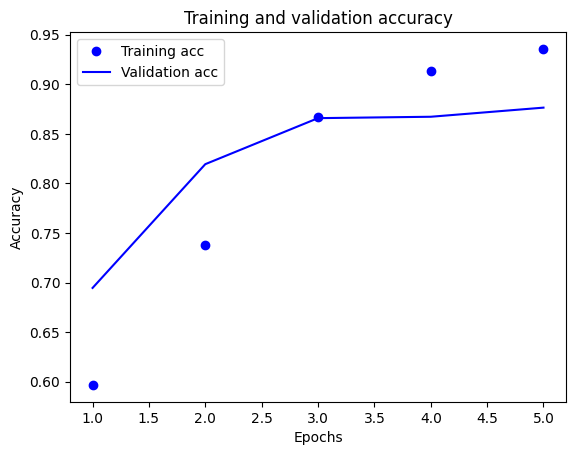

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Evaluación del modelo

In [ ]:
results = model.evaluate(ds.x_test, ds.y_test)

782/782 [==============================] - 4s 5ms/step - loss: 0.3150 - accuracy: 0.8678
